In [1]:
import os
import sys
sys.path.append('/Users/mnannan/dev/supelec/ngsa/assignments/Assignement 2 ')

from main import pipeline
from core.io.loader import *
from features.features_extractor import FeaturesExtractor
from features.processing import features_processing
from models.cross_validation import *
from plot.features_importances import plot_features_importance

from datetime import datetime

%matplotlib inline



In [119]:
import matplotlib.pyplot as plt

In [6]:
import lightgbm as lgb

/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('../data/train_2019-01-12.csv')

In [3]:
test = pd.read_csv('../data/test_2019-01-12.csv')

In [126]:
selected_columns = [
    'title_overlap',
    'publication_date_diff',
    'common_authors',
    'same_journal',
    'authors_collaboration',
    'collaboration_min_distance',
    'collaboration_mean_distance',
    'writer_in_target_paper',
    'writer_collaborators',
    'writer_collaboration_min_distance',
    'writer_collaboration_mean_distance',
    'source_paper_citations',
    'target_paper_citations',
    'source_number_of_papers_cited',
    'target_number_of_papers_cited',
    'adamic_adar',
    'common_neighbors',
    'jaccard_coefficient',
    'preferential_attachment',
    'max_authors_adamic_adar',
    'max_authors_common_neighbors',
    'max_authors_jaccard_coefficient',
    'max_authors_preferential_attachment',
    'title_cosine_similarity',
    'abstract_cosine_similarity',
    'journal_cosine_similarity', 
    'source_title_target_abstract_cosimilarity',
    'source_abstract_target_title_cosimilarity',
    'pagerank_source',
    'pagerank_target'
]

x_train = features_processing(train[selected_columns]).values
x_test = features_processing(test[selected_columns]).values
y = train.category.values

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
from sklearn.model_selection import KFold

In [165]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [125]:
kf = KFold(n_splits=5, random_state=123, shuffle=True)

In [131]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': 
}

### Cross validation

In [166]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': 0,
    'max_bin': 1024,
    'seed': 123,
    'num_leaf': 100
}
f1_scores = []
i = 1
for train_index, test_index in kf.split(x_train):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_train, X_train_validation, y_train_train, y_train_validation = train_test_split(X_train,y_train, train_size=0.8, test_size=0.2)
    lgb_train = lgb.Dataset(X_train_train, y_train_train)
    lgb_validation = lgb.Dataset(X_train_validation, y_train_validation, reference=lgb_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 1000,
                valid_sets=lgb_validation,  # eval training data
                feature_name=selected_columns,
                early_stopping_rounds=10,
                feval=lgb_f1_score,
                verbose_eval=25
            )
    y_pred = (gbm.predict(X_test) > 0.5).astype('int')
    f1_scores.append(f1_score(y_test, y_pred))
    print(f'Epoch {i}: {f1_score(y_test, y_pred)}')
np.mean(f1_scores)
    
    
    

Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.102701	valid_0's f1: 0.977631
[50]	valid_0's binary_logloss: 0.0712335	valid_0's f1: 0.978392
[75]	valid_0's binary_logloss: 0.0682356	valid_0's f1: 0.9788
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.0682356	valid_0's f1: 0.9788
Epoch 1: 0.9783658170914543
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.103634	valid_0's f1: 0.977502
[50]	valid_0's binary_logloss: 0.0722506	valid_0's f1: 0.978138
[75]	valid_0's binary_logloss: 0.069325	valid_0's f1: 0.978415
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0693099	valid_0's f1: 0.978567
Epoch 1: 0.9787905899689491
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.102371	valid_0's f1: 0.978002
[50]	valid_0's binary_logloss: 0.0710283	valid_0's f1: 0.978649
Early stopping, best iteration is:
[53]	valid_0's binary

0.9787629444571315

In [157]:
f1_scores = []
i = 1
params = {
    'objective': 'binary',
    'metric': 'xentropy',
    'verbose': 0,
    'max_bin': 1024,
    'seed': 123
}
for train_index, test_index in kf.split(x_train):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_train, X_train_validation, y_train_train, y_train_validation = train_test_split(X_train,y_train, train_size=0.8, test_size=0.2)
    lgb_train = lgb.Dataset(X_train_train, y_train_train)
    lgb_validation = lgb.Dataset(X_train_validation, y_train_validation, reference=lgb_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 1000,
                valid_sets=lgb_validation,  # eval training data
                feature_name=selected_columns,
                early_stopping_rounds=10,
                feval=lgb_f1_score,
                verbose_eval=25
            )
    y_pred = (gbm.predict(X_test) > 0.5).astype('int')
    f1_scores.append(f1_score(y_test, y_pred))
    print(f'Epoch {i}: {f1_score(y_test, y_pred)}')
np.mean(f1_scores)
    
    
    

Training until validation scores don't improve for 10 rounds.
[25]	valid_0's xentropy: 0.107169	valid_0's f1: 0.9765
[50]	valid_0's xentropy: 0.0742366	valid_0's f1: 0.977667
[75]	valid_0's xentropy: 0.0697341	valid_0's f1: 0.978204
Early stopping, best iteration is:
[78]	valid_0's xentropy: 0.0695813	valid_0's f1: 0.978307
Epoch 1: 0.9781489171907677
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's xentropy: 0.107417	valid_0's f1: 0.976671
[50]	valid_0's xentropy: 0.0743356	valid_0's f1: 0.97751
[75]	valid_0's xentropy: 0.0697527	valid_0's f1: 0.978106
[100]	valid_0's xentropy: 0.0698929	valid_0's f1: 0.9781
Early stopping, best iteration is:
[91]	valid_0's xentropy: 0.0687274	valid_0's f1: 0.97831
Epoch 1: 0.9788040331736807
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's xentropy: 0.107187	valid_0's f1: 0.976003
[50]	valid_0's xentropy: 0.0740076	valid_0's f1: 0.977315
[75]	valid_0's xentropy: 0.0694763	valid_0's f1: 0.977867


0.9786150752250016

In [156]:
f1_scores = []
i = 1
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': 0,
    'max_bin': 1024,
    'seed': 123
}
for train_index, test_index in kf.split(x_train):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_train, X_train_validation, y_train_train, y_train_validation = train_test_split(X_train,y_train, train_size=0.8, test_size=0.2)
    lgb_train = lgb.Dataset(X_train_train, y_train_train)
    lgb_validation = lgb.Dataset(X_train_validation, y_train_validation, reference=lgb_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 1000,
                valid_sets=lgb_validation,  # eval training data
                feature_name=selected_columns,
                early_stopping_rounds=10,
                feval=lgb_f1_score,
                verbose_eval=25
            )
    y_pred = (gbm.predict(X_test) > 0.5).astype('int')
    f1_scores.append(f1_score(y_test, y_pred))
    print(f'Epoch {i}: {f1_score(y_test, y_pred)}')
np.mean(f1_scores)
    
    
    

Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.107029	valid_0's f1: 0.976429
[50]	valid_0's binary_logloss: 0.0741576	valid_0's f1: 0.977647
[75]	valid_0's binary_logloss: 0.0698099	valid_0's f1: 0.978248
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.0694406	valid_0's f1: 0.97837
Epoch 1: 0.9780283210518819
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.108159	valid_0's f1: 0.976129
[50]	valid_0's binary_logloss: 0.0755487	valid_0's f1: 0.977426
[75]	valid_0's binary_logloss: 0.0713391	valid_0's f1: 0.978202
[100]	valid_0's binary_logloss: 0.0704505	valid_0's f1: 0.978384
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.0704505	valid_0's f1: 0.978384
Epoch 1: 0.9787262831885015
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.105817	valid_0's f1: 0.977349
[50]	valid_0's binary_logloss: 0.0725866	valid_0's

0.9786064794597727

In [145]:
f1_scores = []
i = 1
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': 
}
for train_index, test_index in kf.split(x_train):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_train, X_train_validation, y_train_train, y_train_validation = train_test_split(X_train,y_train, train_size=0.8, test_size=0.2)
    lgb_train = lgb.Dataset(X_train_train, y_train_train)
    lgb_validation = lgb.Dataset(X_train_validation, y_train_validation, reference=lgb_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 1000,
                valid_sets=lgb_validation,  # eval training data
                feature_name=selected_columns,
                early_stopping_rounds=10,
                feval=lgb_f1_score,
                verbose_eval=25
            )
    y_pred = (gbm.predict(X_test) > 0.5).astype('int')
    f1_scores.append(f1_score(y_test, y_pred))
    print(f'Epoch {i}: {f1_score(y_test, y_pred)}')
np.mean(f1_scores)
    
    
    

Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.104602	valid_0's f1: 0.977308
[50]	valid_0's binary_logloss: 0.0708553	valid_0's f1: 0.978596
[75]	valid_0's binary_logloss: 0.0663894	valid_0's f1: 0.979151
[100]	valid_0's binary_logloss: 0.0703851	valid_0's f1: 0.978994
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.0654848	valid_0's f1: 0.979417
Epoch 1: 0.9781625997975936
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.108006	valid_0's f1: 0.976108
[50]	valid_0's binary_logloss: 0.0753712	valid_0's f1: 0.977347
[75]	valid_0's binary_logloss: 0.070944	valid_0's f1: 0.977884
[100]	valid_0's binary_logloss: 0.0704005	valid_0's f1: 0.977902
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.0704539	valid_0's f1: 0.97796
Epoch 1: 0.9787506015399422
Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.106498	valid_0's 

0.978590704340926

###### Final train

In [173]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': 0,
    'max_bin': 1024,
    'seed': 123,
    'num_leaf': 100
}

In [174]:
X_train, X_validation, y_train, y_validation = train_test_split(x_train, y, train_size=0.8, test_size=0.2)
lgb_train = lgb.Dataset(X_train_train, y_train_train)
lgb_validation = lgb.Dataset(X_train_validation, y_train_validation, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
gbm = lgb.train(params,
            lgb_train,
            num_boost_round = 1000,
            valid_sets=lgb_validation,  # eval training data
            feature_name=selected_columns,
            early_stopping_rounds=10,
            feval=lgb_f1_score,
            verbose_eval=25
        )

Training until validation scores don't improve for 10 rounds.
[25]	valid_0's binary_logloss: 0.102813	valid_0's f1: 0.977777
[50]	valid_0's binary_logloss: 0.0711963	valid_0's f1: 0.978522
[75]	valid_0's binary_logloss: 0.0680423	valid_0's f1: 0.978944
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.067984	valid_0's f1: 0.979162


In [175]:
y_pred = (gbm.predict(x_test) > 0.5).astype('int')

In [176]:
date = datetime.now().isoformat().split(".")[0]
prediction_name = 'lgbm_{date}.csv'.format(date=date)
prediction_dir = '../submissions'
y_pred = pd.Series(data=y_pred).rename('category').rename_axis('id', axis='index')
y_pred.to_csv(os.path.join(prediction_dir, prediction_name), header=True)

In [171]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=4):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()
def render_tree(tree_index, show_info, precision=4):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(gbm, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

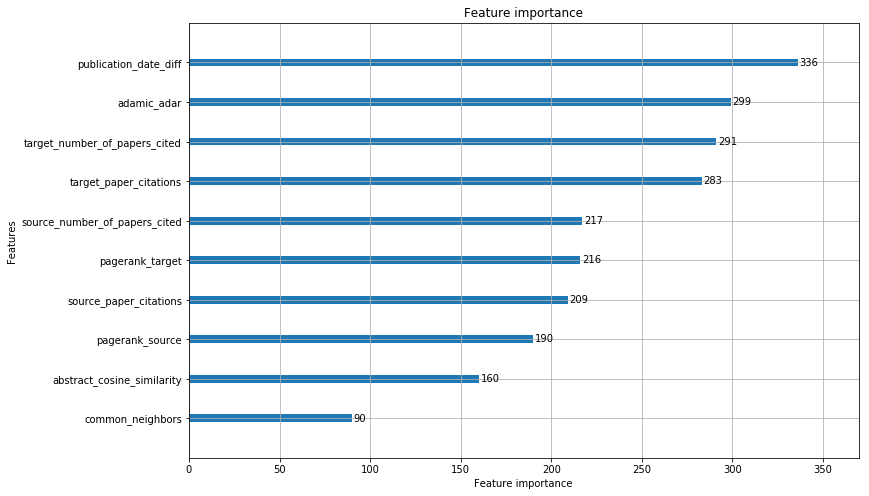

In [172]:
render_plot_importance(importance_type='split')
